In [1]:
import rioxarray
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Polygon
from osgeo import gdal
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 
# Adjust plot font sizes
sns.set(font_scale=1.5)
sns.set_style("white")

In [19]:

filepath="data\AustriaHugeImage.tif"
raster = gdal.Open(filepath)
print(raster.GetMetadata_List())
print(raster.GetProjectionRef())

['AREA_OR_POINT=Area', 'DataType=Generic']
PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","3035"]]


AUSTRIA HUGE TILES

epsg:3035
7


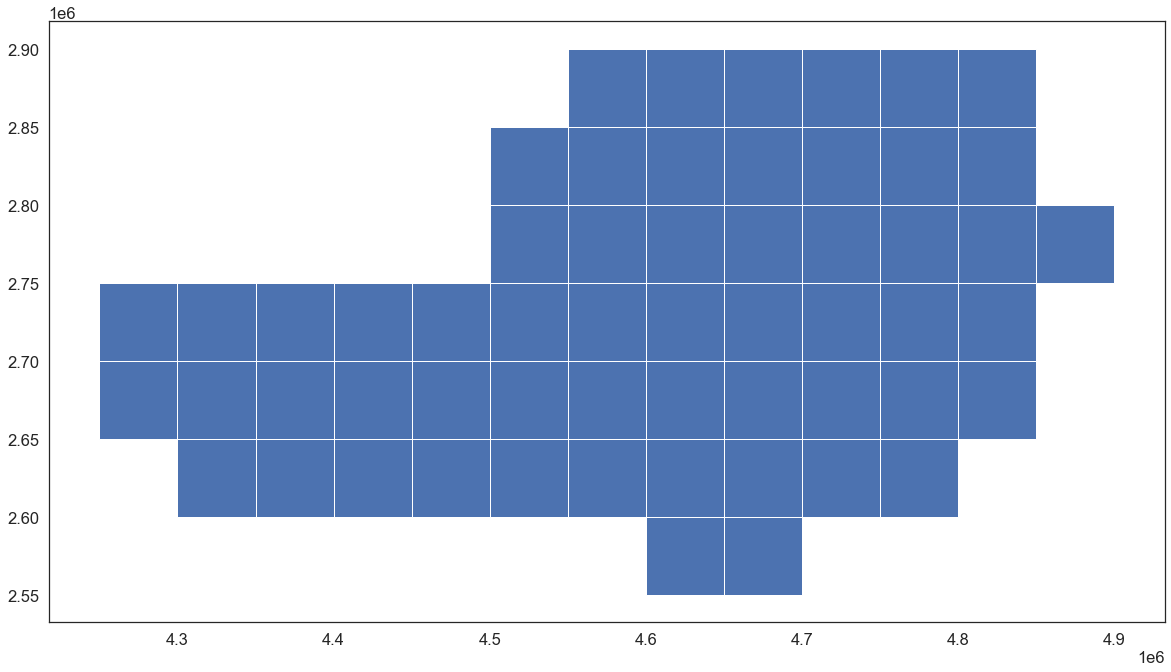

In [11]:
xmin,ymin,xmax,ymax =  [4250000,2550000,4900000,2900000]
width = 50000
height = 50000
rows = int(np.ceil((ymax-ymin) /  height))
cols = int(np.ceil((xmax-xmin) / width))
XleftOrigin = xmin
XrightOrigin = xmin + width
YtopOrigin = ymax
YbottomOrigin = ymax- height
no_data_cell= [
    0,1,2,5,6,7,8,9,13,14,15,16,20,21,22,23,27,28,29,30,34,35,41,48,69,76,82,83,84,85,87,88,89,90
    ]
cell_number=0
polygons = []
for i in range(cols):
    Ytop = YtopOrigin
    Ybottom =YbottomOrigin
    for j in range(rows):
        if(cell_number in no_data_cell):
            Ytop = Ybottom
            Ybottom = Ybottom - height
            cell_number=cell_number+1
        else:
            new_Polygon=Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)])
            new_Polygon._crs="epsg:3035"
            #print(new_Polygon._crs)
            polygons.append(new_Polygon) 
            Ytop = Ybottom
            Ybottom = Ybottom - height
            cell_number=cell_number+1
    XleftOrigin = XrightOrigin
    XrightOrigin = XrightOrigin + width
grid = gpd.GeoDataFrame({'geometry':polygons})
grid =grid.set_crs("epsg:3035")
print(grid.crs)
grid.to_file("grids\AustriaGrid\Austriagrid.shp")
grid.plot(figsize=(20,20))
print(rows)

Grid for a tile

epsg:3035
100


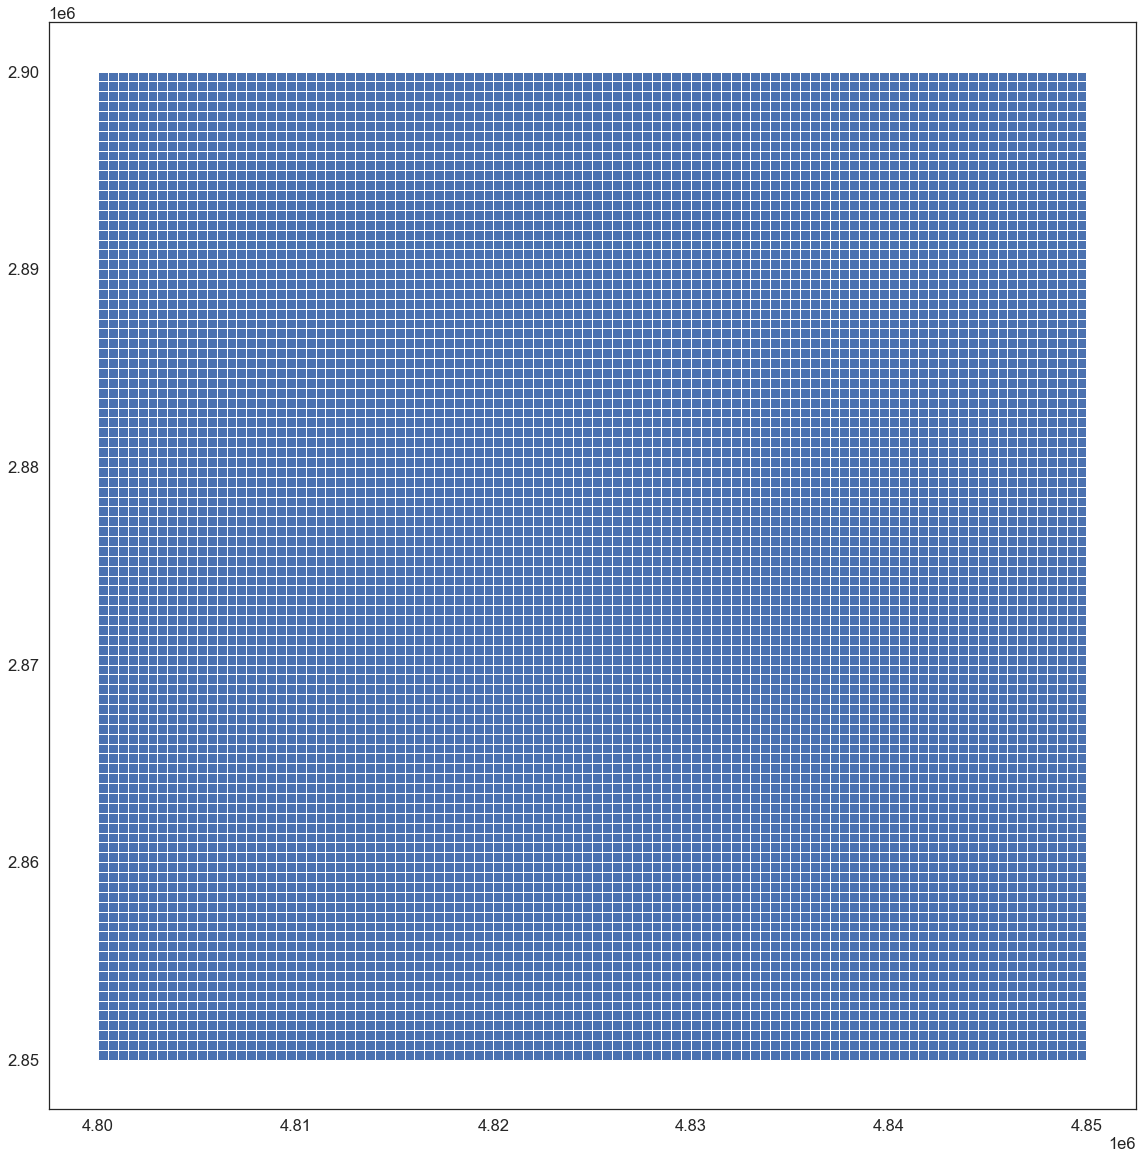

In [4]:
#The grid is already created with the same dimesions of the web site
#Now lets make a grid for each tile
xmin,ymin,xmax,ymax =  [4800000,2850000,4850000,2900000]
width = 500
height = 500
rows = int(np.ceil((ymax-ymin) /  height))
cols = int(np.ceil((xmax-xmin) / width))
XleftOrigin = xmin
XrightOrigin = xmin + width
YtopOrigin = ymax
YbottomOrigin = ymax- height
cell_number=0
polygons = []
for i in range(cols):
    Ytop = YtopOrigin
    Ybottom =YbottomOrigin
    for j in range(rows):
        new_Polygon=Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)])
        new_Polygon._crs="epsg:3035"
        #print(new_Polygon._crs)
        polygons.append(new_Polygon) 
        Ytop = Ybottom
        Ybottom = Ybottom - height
        cell_number=cell_number+1
    XleftOrigin = XrightOrigin
    XrightOrigin = XrightOrigin + width
grid = gpd.GeoDataFrame({'geometry':polygons})
grid =grid.set_crs("epsg:3035")
print(grid.crs)
grid.to_file("grids\TileGrid\TileGrid.shp")
grid.plot(figsize=(20,20))
print(rows)

Single tile of the Grid

In [35]:
singleTile= gpd.GeoDataFrame({'geometry':[grid.loc[rows-3, ('geometry')]]})
singleTile =singleTile.set_crs("epsg:3035")
singleTile.to_file("grids\SingleTile3\SingleTile3.shp")

Now lets try to cut the hugeAustriaTile with gdal

In [32]:
#This is a command line to crop the image and kepp all the geo Information on
!gdalwarp -cutline grids/SingleTile2/SingleTile2.shp -crop_to_cutline data/AustriaHugeImage.tif data/AustriaHugeClip2.tif

Creating output file that is 2500P x 2500L.
Processing data/AustriaHugeImage.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [7]:
#Try its "Gdal Python way"

raster = gdal.Warp('data/AustriaHugeClip33.tif',"data\AustriaHugeImage.tif",polygon=gpd.GeoDataFrame({'geometry':[grid.loc[rows-4, ('geometry')]]}),cropToCutline=True)

raster = None

TypeError: WarpOptions() got an unexpected keyword argument 'polygon'

In [33]:
#Check the information fo the tiles after clipping
!gdalinfo data/AustriaHugeClip2.tif

Driver: GTiff/GeoTIFF
Files: data/AustriaHugeClip2.tif
Size is 2500, 2500
Coordinate System is:
PROJCRS["ETRS89-extended / LAEA Europe",
    BASEGEOGCRS["ETRS89",
        ENSEMBLE["European Terrestrial Reference System 1989 ensemble",
            MEMBER["European Terrestrial Reference Frame 1989"],
            MEMBER["European Terrestrial Reference Frame 1990"],
            MEMBER["European Terrestrial Reference Frame 1991"],
            MEMBER["European Terrestrial Reference Frame 1992"],
            MEMBER["European Terrestrial Reference Frame 1993"],
            MEMBER["European Terrestrial Reference Frame 1994"],
            MEMBER["European Terrestrial Reference Frame 1996"],
            MEMBER["European Terrestrial Reference Frame 1997"],
            MEMBER["European Terrestrial Reference Frame 2000"],
            MEMBER["European Terrestrial Reference Frame 2005"],
            MEMBER["European Terrestrial Reference Frame 2014"],
            ELLIPSOID["GRS 1980",6378137,298.25722